# Sales Win Prediction (Commented Copy)

This notebook recreates your pipeline with clear comments. We train RandomForest, LightGBM, and a Stacked model, but deploy RandomForest via FastAPI because it achieved the best ROC-AUC.

In [11]:
# # Install all required packages for this notebook
# %pip install numpy pandas matplotlib seaborn scikit-learn lightgbm joblib fastapi

# 1) Generate synthetic sales data with a realistic, non-linear win probability
import numpy as np
import pandas as pd


def generate_sales_data(n=1000, random_state=42):
    """Create a synthetic dataset with base CRM-like features and a hidden win process.

    Returns a DataFrame with columns:
      opportunity_size, meetings_held, actions_completed, days_open, stage, win
    """
    np.random.seed(random_state)

    # Base features (simple, interpretable distributions)
    df = pd.DataFrame({
        "opportunity_size": np.random.randint(5000, 100000, n),
        "meetings_held": np.random.poisson(3, n),
        "actions_completed": np.random.poisson(5, n),
        "days_open": np.random.randint(5, 200, n),
        "stage": np.random.choice([1, 2, 3, 4, 5], size=n, p=[0.2, 0.25, 0.25, 0.2, 0.1]),
    })

    # Hidden non-linear formula for win propensity
    logits = (
        0.00007 * df["opportunity_size"]
        + 0.35 * np.log1p(df["meetings_held"])  # diminishing returns on meetings
        + 0.25 * np.sqrt(df["actions_completed"])  # diminishing returns on actions
        + 0.4 * (df["stage"] >= 4).astype(int)  # big lift late in funnel
        + 0.15 * (df["stage"] == 5).astype(int)  # extra push at closed-won
        - 0.03 * np.log1p(df["days_open"])  # old deals decay
        + 0.2 * ((df["meetings_held"] > 3) & (df["stage"] >= 3)).astype(int)  # interaction
    )

    # Sigmoid-transform logits to probabilities, centered around mean for spread
    probs = 1 / (1 + np.exp(-0.5 * (logits - logits.mean())))

    # Sample binary outcomes from probabilities
    df["win"] = np.random.binomial(1, probs)
    return df

# Example run
df = generate_sales_data(1000)
print(df.head())
print("\nWin/Loss distribution:")
print(df["win"].value_counts(normalize=True))
print("\nCorrelations with target:")
print(df.corr(numeric_only=True)["win"].sort_values(ascending=False))

   opportunity_size  meetings_held  actions_completed  days_open  stage  win
0             20795              3                  5         95      5    1
1              5860              5                  9        118      2    0
2             81820              2                  4        182      1    0
3             59886              4                  5         93      2    1
4             11265              3                  7        158      1    0

Win/Loss distribution:
win
1    0.5
0    0.5
Name: proportion, dtype: float64

Correlations with target:
win                  1.000000
opportunity_size     0.469450
stage                0.065093
meetings_held        0.040470
actions_completed    0.037328
days_open            0.021221
Name: win, dtype: float64


In [12]:
# 2) Feature engineering helper used in both training and API
import numpy as np
import pandas as pd


def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Interaction/Rate Features
    df["meeting_ratio"] = df["meetings_held"] / (df["days_open"] + 1)
    df["actions_per_meeting"] = df["actions_completed"] / (df["meetings_held"] + 1)
    df["actions_per_day"] = df["actions_completed"] / (df["days_open"] + 1)
    df["sales_velocity"] = df["opportunity_size"] / (df["days_open"] + 1)

    # Opportunity Value Transformations
    df["log_opportunity_size"] = np.log1p(df["opportunity_size"])
    df["opp_per_meeting"] = df["opportunity_size"] / (df["meetings_held"] + 1)

    # Pipeline Stage Features
    df["stage_squared"] = df["stage"] ** 2
    df["stage_meeting_interaction"] = df["stage"] * df["meetings_held"]

    # Time-based Features
    median_days = df["days_open"].median() if "days_open" in df else 0
    df["fast_deal"] = (df["days_open"] < median_days).astype(int)
    df["deal_age_bucket"] = pd.cut(
        df["days_open"], bins=[-1, 30, 60, 90, 180, np.inf], labels=[1, 2, 3, 4, 5]
    ).astype(int)

    # Binary Indicators
    median_size = df["opportunity_size"].median() if "opportunity_size" in df else 0
    median_actions = df["actions_completed"].median() if "actions_completed" in df else 0
    df["high_value"] = (df["opportunity_size"] > median_size).astype(int)
    df["high_activity"] = (df["actions_completed"] > median_actions).astype(int)

    return df

# Apply features to training data
df = make_features(df)
df.head()

,opportunity_size,meetings_held,actions_completed,days_open,stage,win,meeting_ratio,actions_per_meeting,actions_per_day,sales_velocity,log_opportunity_size,opp_per_meeting,stage_squared,stage_meeting_interaction,fast_deal,deal_age_bucket,high_value,high_activity
0,20795,3,5,95,5,1,0.031250,1.250000,0.052083,216.614583,9.942516,5198.750000,25,15,1,4,0,0
1,5860,5,9,118,2,0,0.042017,1.500000,0.075630,49.243697,8.676076,976.666667,4,10,0,4,0,1
2,81820,2,4,182,1,0,0.010929,1.333333,0.021858,447.103825,11.312289,27273.333333,1,2,0,5,1,0
3,59886,4,5,93,2,1,0.042553,1.000000,0.053191,637.085106,11.000215,11977.200000,4,8,1,4,1,0
4,11265,3,7,158,1,0,0.018868,1.750000,0.044025,70.849057,9.329545,2816.250000,1,3,0,4,0,1


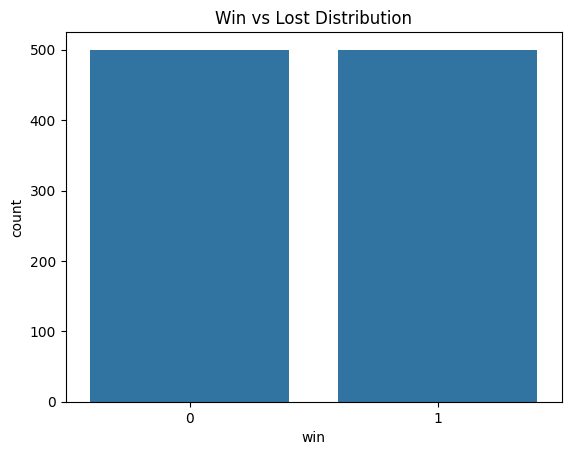

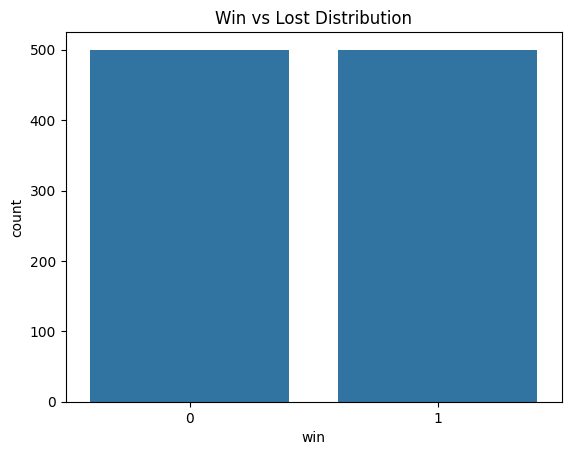

,opportunity_size,meetings_held,actions_completed,days_open,stage,win,meeting_ratio,actions_per_meeting,actions_per_day,sales_velocity,log_opportunity_size,opp_per_meeting,stage_squared,stage_meeting_interaction,fast_deal,deal_age_bucket,high_value,high_activity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000
mean,52442.588000,3.035000,4.990000,101.930000,2.774000,0.50000,0.059695,1.610865,0.094329,985.966888,10.655076,16790.479362,9.282000,8.365000,0.496000,3.21200,0.50000,0.375000
std,28165.681985,1.804725,2.251437,57.803065,1.260362,0.50025,0.096704,1.330924,0.132088,1424.076938,0.737188,15285.313819,7.368363,6.712588,0.500234,1.25564,0.50025,0.484365
min,5055.000000,0.000000,0.000000,5.000000,1.000000,0.00000,0.000000,0.000000,0.000000,25.790816,8.528331,790.500000,1.000000,0.000000,0.000000,1.00000,0.00000,0.000000
25%,28058.000000,2.000000,3.000000,52.000000,2.000000,0.00000,0.015152,0.800000,0.028726,281.439849,10.242065,7025.875000,4.000000,4.000000,0.000000,2.00000,0.00000,0.000000
50%,53031.000000,3.000000,5.000000,101.000000,3.000000,0.50000,0.028674,1.250000,0.049238,520.482265,10.878649,12870.291667,9.000000,6.000000,0.000000,4.00000,0.50000,0.000000
75%,76915.500000,4.000000,6.000000,153.000000,4.000000,1.00000,0.054671,2.000000,0.094755,1024.542500,11.250476,21424.458333,16.000000,12.000000,1.000000,4.00000,1.00000,1.000000
max,99856.000000,10.000000,13.000000,199.000000,5.000000,1.00000,1.000000,9.000000,0.916667,13931.166667,11.511494,99841.000000,25.000000,40.000000,1.000000,5.00000,1.00000,1.000000


In [13]:


# 3) Quick EDA: class balance and basic stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="win", data=df)
plt.title("Win vs Lost Distribution")
plt.show()

# Sanity checks
df.isnull().sum()
df.describe()

In [14]:
# 4) Train/test split and scaling (keep consistent across models)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(["win"], axis=1)
y = df["win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save the exact feature order for API inference
FEATURE_COLUMNS = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

RF Baseline Accuracy: 0.685
RF Baseline ROC-AUC: 0.7183999999999999

RF Baseline Report:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       100
           1       0.66      0.76      0.71       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



RF Baseline Accuracy: 0.685
RF Baseline ROC-AUC: 0.7183999999999999

RF Baseline Report:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       100
           1       0.66      0.76      0.71       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



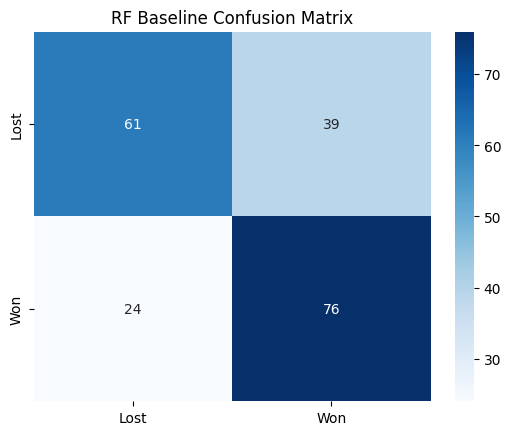

In [15]:
# 5) Baseline model: RandomForest (great for tabular)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

rf_baseline = RandomForestClassifier(n_estimators=300, random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

y_pred = rf_baseline.predict(X_test_scaled)
y_prob = rf_baseline.predict_proba(X_test_scaled)[:, 1]

print("RF Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("RF Baseline ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nRF Baseline Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lost", "Won"], yticklabels=["Lost", "Won"])
plt.title("RF Baseline Confusion Matrix")
plt.show()

In [16]:
# 6) Hyperparameter tuning: RandomForest with GridSearchCV (optimize accuracy)
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gs_rf = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_train_scaled, y_train)

print("Best RF Params:", gs_rf.best_params_)
print("Best RF CV Accuracy:", gs_rf.best_score_)

best_rf = gs_rf.best_estimator_

# Evaluate tuned RF on test set
y_pred = best_rf.predict(X_test_scaled)
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]
print("Tuned RF Test Accuracy:", accuracy_score(y_test, y_pred))
print("Tuned RF Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best RF CV Accuracy: 0.7049999999999998
Tuned RF Test Accuracy: 0.71
Tuned RF Test ROC-AUC: 0.7447


In [18]:
# 7) LightGBM: baseline + tuning (for comparison)

import lightgbm as lgb

lgb_base = lgb.LGBMClassifier(random_state=42)
lgb_base.fit(X_train_scaled, y_train)

y_pred = lgb_base.predict(X_test_scaled)
y_prob = lgb_base.predict_proba(X_test_scaled)[:, 1]
print("LGBM Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("LGBM Baseline ROC-AUC:", roc_auc_score(y_test, y_prob))

# Tuning
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500]
}

gs_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_lgb.fit(X_train_scaled, y_train)
print("Best LGBM Params:", gs_lgb.best_params_)
print("Best LGBM CV Accuracy:", gs_lgb.best_score_)

best_lgb = gs_lgb.best_estimator_
y_pred = best_lgb.predict(X_test_scaled)
y_prob = best_lgb.predict_proba(X_test_scaled)[:, 1]
print("Tuned LGBM Test Accuracy:", accuracy_score(y_test, y_pred))
print("Tuned LGBM Test ROC-AUC:", roc_auc_score(y_test, y_prob))

Note: you may need to restart the kernel to use updated packages.
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [19]:
# 8) Stacking ensemble: RF + LGBM with LogisticRegression meta-learner
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[('rf', best_rf), ('lgbm', best_lgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    stack_method='predict_proba',
)

stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)
y_prob = stack.predict_proba(X_test_scaled)[:, 1]
print("Stack Accuracy:", accuracy_score(y_test, y_pred))
print("Stack ROC-AUC:", roc_auc_score(y_test, y_prob))

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 256, number of negative: 256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam


LightGBM Acc: 0.705
LightGBM ROC-AUC: 0.742


c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zaid5\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam


Stacked Acc: 0.705
Stacked ROC-AUC: 0.744


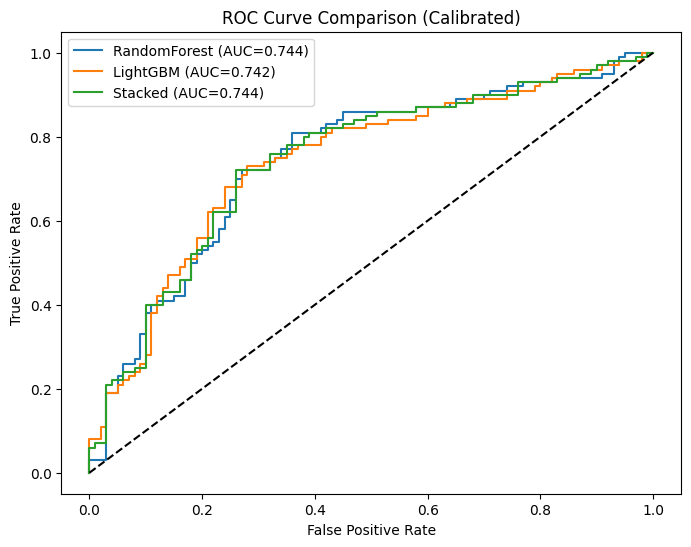

In [20]:
# 9) Cross-validation, calibration, and ROC curves
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

cv_scores = cross_val_score(stack, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Stack CV ROC-AUC:", cv_scores, "Mean:", np.mean(cv_scores))

rf_cal = CalibratedClassifierCV(best_rf, cv=5)
lgb_cal = CalibratedClassifierCV(best_lgb, cv=5)
stack_cal = CalibratedClassifierCV(stack, cv=5)

rf_cal.fit(X_train_scaled, y_train)
lgb_cal.fit(X_train_scaled, y_train)
stack_cal.fit(X_train_scaled, y_train)

models = {"RandomForest": rf_cal, "LightGBM": lgb_cal, "Stacked": stack_cal}
plt.figure(figsize=(8,6))
for name, mdl in models.items():
    y_pred = mdl.predict(X_test_scaled)
    y_prob = mdl.predict_proba(X_test_scaled)[:, 1]
    print(f"\n{name} Acc: {accuracy_score(y_test, y_pred):.3f}")
    print(f"{name} ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1], 'k--')
plt.title("ROC Curve Comparison (Calibrated)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [21]:
# 10) Persist deployment artifacts (RF chosen for best ROC-AUC)
import joblib

joblib.dump(best_rf, "sales_win_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(FEATURE_COLUMNS, "feature_columns.pkl")
print("Saved best RF, scaler, and feature columns for API.")

Saved best RF, scaler, and feature columns for API.


In [ ]:


# 11) FastAPI for inference (uses RandomForest only)
# We deploy RandomForest because it achieved the best ROC-AUC among RF/LGBM/Stack.
from fastapi import FastAPI
import joblib
import pandas as pd

# Load artifacts
model = joblib.load("sales_win_model.pkl")
scaler = joblib.load("scaler.pkl")
FEATURE_COLUMNS = joblib.load("feature_columns.pkl")

app = FastAPI(title="Sales Opportunity Win Predictor (RF)")

# Helper to transform raw input into full feature set
def preprocess_payload(payload: dict) -> pd.DataFrame:
    raw = pd.DataFrame([payload])
    # Ensure required base fields exist
    required = ["opportunity_size", "meetings_held", "actions_completed", "days_open", "stage"]
    missing = [c for c in required if c not in raw.columns]
    if missing:
        raise ValueError(f"Missing fields: {missing}")

    # Build engineered features using the same logic as training
    full = make_features(raw)

    # Reorder/select exactly the training feature columns
    full = full[FEATURE_COLUMNS]
    return full

@app.post("/predict/")
def predict(data: dict):
    try:
        feats = preprocess_payload(data)
        feats_scaled = scaler.transform(feats)
        prob = float(model.predict_proba(feats_scaled)[0][1])
        pred = int(model.predict(feats_scaled)[0])
        return {
            "model": "RandomForest (deployed)",
            "reason": "RF selected due to best ROC-AUC among RF/LGBM/Stack",
            "prediction": "Won" if pred == 1 else "Lost",
            "probability": round(prob, 4),
        }
    except Exception as e:
        return {"error": str(e)}

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Example payload for /predict
# {
#   "opportunity_size": 55000,
#   "meetings_held": 3,
#   "actions_completed": 12,
#   "days_open": 40,
#   "stage": 2
# }
# Expected response keys: model, reason, prediction, probability